## RL for Predictive Maintenance - Evaluation

#### Imports

In [49]:
import pandas as pd
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
import matplotlib.pyplot as plt
import os
from typing import Tuple, Dict, Any, List

#### Global settings

In [50]:
# Data and Environment settings
MODEL_NAME = 'PROC_11'
TEST_DATA = 'TS_PROC_12'

TEST_FILE = f'data\\test_data\\{TEST_DATA}.csv'

# Environment parameters
WEAR_THRESHOLD = 200.0  # Threshold for tool wear before it's considered failed
R1_CONTINUE = 2.0       # Reward for continuing with a healthy tool
R2_REPLACE = -5.0       # Reward for a timely replacement
R3_VIOLATION = -30.0    # Penalty for violating the wear threshold

# Saved model
# REINFORCE_MODEL = f'models/{MODEL_NAME}_REINFORCE_Model.h5'
REINFORCE_MODEL = f'models/PROC_11_REINFORCE_Model_10000.h5'
REINFORCE_AM_MODEL = f'models/{MODEL_NAME}_REINFORCE_AM_Model.h5'
PPO_MODEL = f'models/{MODEL_NAME}_PPO_Model.zip'  # PPO uses .zip extension by default

#### REINFORCE policy

In [51]:
# --- Task 2: REINFORCE Algorithm Implementation ---
# A custom implementation of the REINFORCE algorithm with a structure
# similar to Stable Baselines3 for easy comparison.
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Linear(64, output_dim),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(0)
        return self.net(x)

class REINFORCE:
    """
    A custom REINFORCE agent.
    """
    def __init__(self, policy, env, learning_rate=0.001, gamma=0.99, model_file=None):
        self.env = env
        self.policy = policy
        self.optimizer = optim.Adam(self.policy.parameters(), lr=learning_rate)
        self.gamma = gamma
        self.model_name = "REINFORCE"
        self.model_file = model_file

    def predict(self, obs: np.ndarray) -> int:
        """
        Selects an action based on the current observation.
        Uses the same action selection logic as training for consistency.
        """
        with torch.no_grad():  # Important to disable gradients for prediction
            state_tensor = torch.FloatTensor(obs).unsqueeze(0)
            probs = self.policy(state_tensor)
            dist = Categorical(probs)
            action = dist.sample()  # Sample action like in training
            return action.item()        

    def learn(self, total_episodes: int) -> Dict[str, List]:
        """
        Trains the agent for a given number of episodes.
        """
        print(f"--- Training {self.model_name} ---")
        # Metrics collectors
        all_rewards = []
        all_violations = []
        all_replacements = []
        all_margins = []

        for episode in range(total_episodes):
            log_probs = []
            rewards = []
            obs, _ = self.env.reset()
            done = False
            
            episode_info = {'violation': 0, 'replacement': 0, 'margin': np.nan}

            while not done:
                state_tensor = torch.FloatTensor(obs).unsqueeze(0)
                probs = self.policy(state_tensor)
                dist = Categorical(probs)
                action = dist.sample()

                log_prob = dist.log_prob(action)
                log_probs.append(log_prob)

                obs, reward, terminated, truncated, info = self.env.step(action.item())
                rewards.append(reward)
                done = terminated or truncated

                if info.get('violation'): episode_info['violation'] = 1
                if info.get('replacement'): episode_info['replacement'] = 1
                if not np.isnan(info.get('margin')): episode_info['margin'] = info.get('margin')
            
            # Collect metrics for this episode
            all_rewards.append(sum(rewards))
            all_violations.append(episode_info['violation'])
            all_replacements.append(episode_info['replacement'])
            all_margins.append(episode_info['margin'])

            # Calculate discounted returns
            returns = []
            G = 0
            for r in reversed(rewards):
                G = r + self.gamma * G
                returns.insert(0, G)
            returns = torch.tensor(returns, dtype=torch.float32)
            
            # Normalize returns for stability, but only if there's more than one step
            # to avoid std() of a single item becoming NaN.
            if len(returns) > 1:
                returns = (returns - returns.mean()) / (returns.std() + 1e-9)

            # Calculate policy loss and update weights
            policy_loss = []
            for log_prob, G in zip(log_probs, returns):
                policy_loss.append(-log_prob * G)
            
            self.optimizer.zero_grad()
            policy_loss = torch.cat(policy_loss).sum()
            policy_loss.backward()
            self.optimizer.step()

            if (episode + 1) % 50 == 0:
                print(f"Episode {episode + 1}/{total_episodes}, Total Reward: {sum(rewards):.2f}")
        
        print("--- Training Complete ---")
        
        # Save model if file path was provided
        if self.model_file is not None:
            try:
                # Create directory if it doesn't exist
                os.makedirs(os.path.dirname(self.model_file), exist_ok=True)
                # Save the model
                torch.save({
                    'policy_state_dict': self.policy.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'input_dim': self.policy.net[0].in_features,
                    'output_dim': self.policy.net[-2].out_features
                }, self.model_file)
                print(f"Model saved successfully to: {self.model_file}")
            except Exception as e:
                print(f"Error saving model: {str(e)}")

        return {
            "rewards": all_rewards,
            "violations": all_violations,
            "replacements": all_replacements,
            "margins": all_margins
        }


#### Custom RL Environment for milling tool maintenance
- OpenAI's Gymnasium open standards format

In [52]:
# --- Task 1: Custom Gymnasium Environment ---
# We define the environment for the milling tool maintenance problem.

class MT_Env(gym.Env):
    """
    Custom Gymnasium environment for Milling Tool Predictive Maintenance.

    The agent observes the current tool wear and decides whether to continue
    using the tool or replace it.

    Observation Space: A single continuous value representing the current tool wear.
    Action Space: Two discrete actions - 0 (CONTINUE) or 1 (REPLACE_TOOL).
    """
    metadata = {'render_modes': ['human']}

    def __init__(self, data_file: str, wear_threshold: float, r1: float, r2: float, r3: float):
        """
        Initializes the environment.

        Args:
            data_file (str): Path to the CSV file with sensor data and tool wear.
            wear_threshold (float): The maximum allowable tool wear.
            r1 (float): Reward for continuing.
            r2 (float): Reward for a timely replacement.
            r3 (float): Penalty for a threshold violation.
        """
        super(MT_Env, self).__init__()

        # Load and preprocess data
        if not os.path.exists(data_file):
            raise FileNotFoundError(f"Data file not found at {data_file}. Please ensure the file is in the correct directory.")
        self.df = pd.read_csv(data_file)
        self.max_steps = len(self.df) - 1

        # Environment parameters
        self.wear_threshold = wear_threshold
        self.r1_continue = r1
        self.r2_replace = r2
        self.r3_violation = r3

        # Define action and observation spaces
        self.action_space = spaces.Discrete(2)  # 0: CONTINUE, 1: REPLACE_TOOL
        # The observation is the current tool wear, normalized for better learning
        self.observation_space = spaces.Box(low=0, high=self.wear_threshold * 1.5, shape=(1,), dtype=np.float32)

        # Internal state
        self.current_step = 0

    def reset(self, seed=None, options=None) -> Tuple[np.ndarray, Dict]:
        """
        Resets the environment to its initial state for a new episode.
        """
        super().reset(seed=seed)
        self.current_step = 0
        initial_observation = self._get_observation()
        return initial_observation, {}

    def step(self, action: int) -> Tuple[np.ndarray, float, bool, bool, Dict]:
        """
        Executes one time step within the environment.
        """
        terminated = False
        truncated = False
        reward = 0
        info = {'violation': False, 'replacement': False, 'margin': np.nan}

        current_wear = self.df.loc[self.current_step, 'tool_wear']

        if action == 1:  # Action: REPLACE_TOOL
            reward = self.r2_replace
            terminated = True
            info['replacement'] = True
            info['margin'] = self.wear_threshold - current_wear
        elif action == 0:  # Action: CONTINUE
            self.current_step += 1
            if self.current_step > self.max_steps:
                # Reached the end of data without replacement or violation
                truncated = True
                reward = 0 # No reward or penalty if data runs out
            else:
                next_wear = self.df.loc[self.current_step, 'tool_wear']
                if next_wear >= self.wear_threshold:
                    reward = self.r3_violation
                    terminated = True
                    info['violation'] = True
                    # $$$ Avoid NANs for margin. Even if NOT replaced, see what the margin is
                    info['margin'] = self.wear_threshold - current_wear
                else:
                    reward = self.r1_continue
        
        observation = self._get_observation()
        
        return observation, reward, terminated, truncated, info

    def _get_observation(self) -> np.ndarray:
        """
        Gets the current observation from the dataframe.
        """
        wear = self.df.loc[self.current_step, 'tool_wear']
        return np.array([wear], dtype=np.float32)

    def render(self, mode='human'):
        """
        Renders the environment state (optional, for visualization).
        """
        wear = self.df.loc[self.current_step, 'tool_wear']
        print(f"Step: {self.current_step}, Tool Wear: {wear:.2f}")


class AM_Env(MT_Env):
    """
        Attention-augmented variant of MT_Env.

        - Uses the same sensor features as the dataset.
        Computes attention weights via KernelRidge(kernel='linear') fitted to features -> tool_wear,
        The primal coefficients are used to derive per-feature importances (absolute value, normalized).
        - Observation returned is the normalized feature vector multiplied elementwise by attention weights.
    """

    def _init_(self, data_file: str, wear_threshold: float, r1: float, r2: float, r3: float, kr_alpha: float = 1.0):
        super(AM_Env, self).__init__(data_file, wear_threshold, r1, r2, r3)

        # feature list (same as suggested earlier)
        self.features = ['vib_Spindle', 'Vib_Table', 'Sound_Spindle', 'Sound_table', 'X_Load_Cell', 'Y_Load_Cell', 'Z_Load_Cell', 'Current']

        # ensure features exist
        missing = [f for f in self.features if f not in self.df.columns]
        if missing:
            raise ValueError(f"Missing features in dataset: {missing}")

        # compute per-feature normalization stats
        vals_df = self.df[self.features].astype(np.float32)
        self.feature_means = vals_df.mean(axis=0).to_numpy(dtype=np.float32)
        self.feature_stds = vals_df.std(axis=0).replace(0, 1.0).to_numpy(dtype=np.float32)

        # prepare training data for KernelRidge
        X = (vals_df - self.feature_means) / (self.feature_stds + 1e-9)
        x = x.to_numpy(dtype=np.float32)
        y = self.df['tool_wear'].to_numpy(dtype=np.float32)

        # fit KernelRidge (linear) to estimate feature importances
        try:
            from sklearn.kernel_ridge import KernelRidge
        except Exception as e:
            raise ImportError("scikit-learn is required for AM_Env. Install with `pip install scikit-learn") from e

        self._kr_model = KernelRidge(kernel='linear', alpha=kr_alpha)
        self._kr_model.fit(X, y)

        # compute primal coefficients from dual_coef_ and x_fit_
        # coef = x_fit _. T @ dual_coef_ (shape: n_features,)
        dual=np.asarray(self._kr_model.dual_coef_).reshape(-1, 1) # (n_train, 1)
        x_fit = np.asarray(self._kr_model.x_fit_) # (n_train, n_features)
        coef = (x_fit.T @ dual).ravel() # (n_features,)

        attn = np.abs(coef)
        if attn.sum() == 0:
            attn = np.ones_like(attn)
        attn = attn / (attn.sum() + 1e-12)
        self.attention_weights = attn.astype(np.float32)

        # observation space: attention-weighted feature vector
        self.observation_space = spaces.Box(low =- np.inf, high=np.inf, shape=(len(self.features),), dtype=np.float32)

    def get_observation(self) -> np.ndarray:
        """Return the attention-weighted, normalized feature vector for current step."""
        vals = self.df.loc[self.current_step, self.features].to_numpy(dtype=np.float32)
        norm = (vals - self.feature_means) / (self.feature_stds + 1e-9)
        weighted = norm * self.attention_weights
        return weighted.astype(np.float32)
    
    def recompute_attention(self, window: int = None, kr_alpha: float = None):
        """
            Optionally recompute attention weights:
            - If window'is None -> use full dataset (same as init).
            - If window is int -> use last 'window rows up to current_step to compute local attention.
            - kr_alpha overrides regularization when refitting.
        """
        
        if window is None:
            df_slice = self.df[self.features]
        else:
            start = max(0, self.current_step - window + 1)
            df_slice = self.df.loc[start:self.current_step, self.features]
            if len(df_slice) < 2:
                df_slice = self.df[self.features] # fallback to full data if slice too small

        x = ((df_slice - self.feature_means) / (self.feature_stds + 1e-9)).to_numpy(dtype=np.float32)
        y = self.df.loc[df_slice.index, 'tool_wear'].to_numpy(dtype=np.float32)

        from sklearn.kernel_ridge import KernelRidge
        model = KernelRidge(kernel='linear', alpha=(kr_alpha if kr_alpha is not None else self._kr_model.alpha))
        model.fit(x, y)
        dual = np.asarray(model.dual_coef_).reshape(-1, 1)
        x_fit = np.asarray(model.x_fit )
        coef = (x_fit.T @ dual).ravel()
        attn = np.abs(coef)
        if attn.sum() == 0:
            attn = np.ones_like(attn)
        attn = attn / (attn.sum() + 1e-12)
        self.attention_weights = attn.astype(np.float32)

In [53]:
def test_saved_model(
    model_file: str, 
    test_data_file: str, 
    wear_threshold: float, 
    r1: float, 
    r2: float, 
    r3: float,
    model_type: str = "REINFORCE"
):
    """
    Tests a saved model (REINFORCE or PPO) on new sensor data and visualizes the results.
    
    Args:
        model_file (str): Path to the saved model file
        test_data_file (str): Path to the new sensor data file
        wear_threshold (float): Threshold for tool wear
        r1, r2, r3 (float): Reward parameters for the environment
        model_type (str): Type of model to test ("REINFORCE" or "PPO")
    """
    # Create test environment
    test_env = MT_Env(
        data_file=test_data_file,
        wear_threshold=wear_threshold,
        r1=r1, r2=r2, r3=r3
    )
    
    # Load the appropriate model based on type
    if model_type.upper() == "REINFORCE":
        policy = PolicyNetwork(
            input_dim=test_env.observation_space.shape[0],
            output_dim=test_env.action_space.n
        )
        agent = REINFORCE(policy, test_env)
        try:
            checkpoint = torch.load(model_file)
            agent.policy.load_state_dict(checkpoint['policy_state_dict'])
            print(f"REINFORCE model loaded successfully from: {model_file}")
        except Exception as e:
            print(f"Error loading REINFORCE model: {str(e)}")
            return
    elif model_type.upper() == "PPO":
        try:
            agent = PPO.load(model_file)
            print(f"PPO model loaded successfully from: {model_file}")
        except Exception as e:
            print(f"Error loading PPO model: {str(e)}")
            return
    else:
        raise ValueError("model_type must be either 'REINFORCE' or 'PPO'")
    
    # Test metrics
    total_steps = 0
    total_replacements = 0
    total_violations = 0
    margins = []
    replacement_points = []
    violation_points = []
    wear_trajectory = []
    
    # Run test episode
    obs, _ = test_env.reset()
    done = False
    step = 0
    
    while not done:
        # Get action based on model type
        if model_type.upper() == "REINFORCE":
            action = agent.predict(obs)
        else:  # PPO
            action, _states = agent.predict(obs, deterministic=True)
            
        obs, reward, terminated, truncated, info = test_env.step(action)
        wear = obs[0]
        wear_trajectory.append(wear)
        
        if info.get('replacement'):
            total_replacements += 1
            replacement_points.append((step, wear))
            margins.append(wear_threshold - wear)
        
        if info.get('violation'):
            total_violations += 1
            violation_points.append((step, wear))
            margins.append(wear_threshold - wear)
        
        step += 1
        done = terminated or truncated
    
    total_steps = step
    
    # Calculate metrics
    metrics = {
        'total_steps': total_steps,
        'replacement_rate': total_replacements / total_steps,
        'violation_rate': total_violations / total_steps,
        'avg_margin': np.mean(margins) if margins else np.nan,
        'min_margin': np.min(margins) if margins else np.nan
    }
    
    # Plotting
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    fig.suptitle(f'{model_type} Model Test Results', fontsize=14)
    
    # Plot 1: Wear trajectory with events
    ax1.plot(wear_trajectory, 'b-', alpha=0.6, label='Tool Wear')
    ax1.axhline(y=wear_threshold, color='r', linestyle='--', alpha=0.6, label='Wear Threshold')
    
    # Plot replacement and violation points
    if replacement_points:
        points = np.array(replacement_points)
        ax1.scatter(points[:, 0], points[:, 1], color='g', marker='^', 
                   label='Replacements', alpha=0.6)
    if violation_points:
        points = np.array(violation_points)
        ax1.scatter(points[:, 0], points[:, 1], color='r', marker='x', 
                   label='Violations', alpha=0.6)
    
    ax1.set_title('Tool Wear Trajectory')
    ax1.set_xlabel('Step')
    ax1.set_ylabel('Wear')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot 2: Margins histogram
    if margins:
        ax2.hist(margins, bins=20, alpha=0.6, color='purple')
        ax2.axvline(x=0, color='r', linestyle='--', alpha=0.6)
        ax2.set_title('Distribution of Margins at Decision Points')
        ax2.set_xlabel('Margin (Threshold - Wear)')
        ax2.set_ylabel('Frequency')
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print metrics
    print(f"\n{model_type} Test Results:")
    print(f"Total Steps: {metrics['total_steps']}")
    print(f"Replacement Rate: {metrics['replacement_rate']:.4f}")
    print(f"Violation Rate: {metrics['violation_rate']:.4f}")
    print(f"Average Margin: {metrics['avg_margin']:.2f}")
    print(f"Minimum Margin: {metrics['min_margin']:.2f}")
    
    return metrics

#### Create the environments

In [54]:
# Create a base environment for the custom REINFORCE agent
reinforce_env = MT_Env(
    data_file=TEST_FILE,
    wear_threshold=WEAR_THRESHOLD,
    r1=R1_CONTINUE,
    r2=R2_REPLACE,
    r3=R3_VIOLATION
)
check_env(reinforce_env)

# Create the environment with attention mechanism
reinforce_am_env = AM_Env(
    data_file=TEST_FILE,
    wear_threshold=WEAR_THRESHOLD,
    r1=R1_CONTINUE,
    r2=R2_REPLACE,
    r3=R3_VIOLATION)

check_env(reinforce_am_env)

# Create a separate, monitored environment for the Stable Baselines3 PPO agent
ppo_env = Monitor(MT_Env(
    data_file=TEST_FILE,
    wear_threshold=WEAR_THRESHOLD,
    r1=R1_CONTINUE,
    r2=R2_REPLACE,
    r3=R3_VIOLATION
))

#### Model evaluation

In [55]:
def test_REINFORCE(model_file: str, test_file: str,
                   wear_threshold: float = WEAR_THRESHOLD,
                   r1: float = R1_CONTINUE, r2: float = R2_REPLACE, r3: float = R3_VIOLATION):
    """
    Test a saved REINFORCE model on a test CSV (time-series).
    - model_file: path to saved checkpoint containing 'policy_state_dict'
    - test_file: path to CSV with sensor rows (and an ACTION_CODE column for ground-truth)
    Returns: dict with precision, recall, f1, accuracy and predicted_actions list.
    """
    import pandas as pd
    import numpy as np
    import torch
    from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

    # create test environment from file
    env = MT_Env(data_file=test_file, wear_threshold=wear_threshold, r1=r1, r2=r2, r3=r3)

    # load checkpoint
    try:
        ckpt = torch.load(model_file, map_location="cpu")
    except Exception as e:
        print(f"Error loading model '{model_file}': {e}")
        return None

    # instantiate policy network matching env
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n
    policy = PolicyNetwork(input_dim, output_dim)
    try:
        policy.load_state_dict(ckpt["policy_state_dict"])
    except Exception:
        # fallback: try to load entire ckpt if saved differently
        try:
            policy.load_state_dict(ckpt)
        except Exception as e:
            print(f"Failed to load policy state dict: {e}")
            return None
    policy.eval()

    # run through time-series once, collecting predicted actions
    obs, _ = env.reset()
    done = False
    predicted_actions = []
    while not done:
        with torch.no_grad():
            t = torch.FloatTensor(obs).unsqueeze(0) if obs.ndim == 1 else torch.FloatTensor(obs)
            probs = policy(t).squeeze(0).cpu().numpy()
            action = int(np.argmax(probs))  # deterministic for testing
        predicted_actions.append(action)
        # print(f' ---- Pred Action {action}')
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

    # load ground-truth action codes from CSV
    df = pd.read_csv(test_file)
    # try common column names
    for col in ["ACTION_CODE"]:
        if col in df.columns:
            gt_col = col
            break
    else:
        print("Ground-truth ACTION_CODE column not found.")
        return None

    y_true_full = df[gt_col].astype(int).to_numpy()
    # align lengths
    n = len(predicted_actions)
    y_true = y_true_full[:n]

    # compute metrics (handle edge cases)
    precision = precision_score(y_true, predicted_actions, zero_division=0)
    recall = recall_score(y_true, predicted_actions, zero_division=0)
    f1 = f1_score(y_true, predicted_actions, zero_division=0)
    acc = accuracy_score(y_true, predicted_actions)

    metrics = {
        "precision": float(precision),
        "recall": float(recall),
        "f1": float(f1),
        "accuracy": float(acc),
        "predicted_actions": predicted_actions
    }

    print(f"REINFORCE test results — precision: {precision:.4f}, recall: {recall:.4f}, f1: {f1:.4f}, acc: {acc:.4f}")
    return metrics

In [56]:
X = test_REINFORCE(REINFORCE_MODEL, TEST_FILE)

REINFORCE test results — precision: 0.0000, recall: 0.0000, f1: 0.0000, acc: 1.0000


C:\Users\Rajesh\AppData\Local\Temp\ipykernel_23064\860974779.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(model_file, map_location="cpu")


#### Utilities: create_time_series_test_for_folder

In [57]:
# import pandas as pd
# import os
# from typing import List, Optional

# def create_time_series_test_for_folder(
#     folder_path: str,
#     target_total: int = 50,
#     file_suffix: str = ".csv",
#     output_prefix: str = "TS_"
# ) -> List[str]:
#     """
#     For every file in folder_path ending with file_suffix, create a balanced time-series test set
#     based on the ACTION_CODE column and save it as TS_<original_filename>.csv in the same folder.
#     Behavior:
#       - Expects exactly two ACTION_CODE classes per file.
#       - For each file, per-class sample count = min(available_per_class, target_total//2).
#       - Sampling is sequential nth sampling within each class to preserve time order.
#       - If a file cannot produce a balanced set (missing ACTION_CODE, not binary, or no samples),
#         it is skipped and not written.
#     Returns a list of full paths to saved TS_ files.
#     """
#     saved_paths: List[str] = []

#     if not os.path.isdir(folder_path):
#         raise ValueError(f"Not a directory: {folder_path}")

#     for name in os.listdir(folder_path):
#         if not name.lower().endswith(file_suffix.lower()):
#             continue
#         src_path = os.path.join(folder_path, name)
#         try:
#             df = pd.read_csv(src_path)
#         except Exception:
#             continue

#         if 'ACTION_CODE' not in df.columns:
#             continue

#         classes = sorted(df['ACTION_CODE'].unique())
#         if len(classes) != 2:
#             continue

#         # preserve file order (time series). assume file already sorted by Time column if present.
#         class_counts = df['ACTION_CODE'].value_counts().to_dict()
#         min_class_count = min(class_counts.get(classes[0], 0), class_counts.get(classes[1], 0))
#         if min_class_count == 0:
#             continue

#         per_class = min(min_class_count, target_total // 2)
#         if per_class == 0:
#             continue

#         sampled_pieces = []
#         for cls in classes:
#             cls_df = df[df['ACTION_CODE'] == cls].reset_index()  # keep original index in 'index' col
#             total = len(cls_df)
#             step = max(1, total // per_class)
#             chosen_positions = [i * step for i in range(per_class)]
#             # adjust positions if out of bounds to keep them monotonic and valid
#             for i in range(len(chosen_positions)):
#                 if chosen_positions[i] >= total:
#                     chosen_positions[i] = total - 1 - (len(chosen_positions) - 1 - i)
#                     if chosen_positions[i] < 0:
#                         chosen_positions[i] = 0
#             chosen_idx = cls_df.loc[chosen_positions, 'index'].to_list()
#             sampled_pieces.append(df.loc[chosen_idx])

#         result = pd.concat(sampled_pieces).sort_index().reset_index(drop=True)
#         out_name = f"{output_prefix}{name}"
#         out_path = os.path.join(folder_path, out_name)
#         try:
#             result.to_csv(out_path, index=False)
#             saved_paths.append(out_path)
#         except Exception:
#             continue

#     return saved_paths

# outs = create_time_series_test_for_folder(TEST_FILE, target_total=60)
# print(outs)

#### TESTING: Code from Training 

In [58]:
def test_saved_model(
    model_file: str, 
    test_data_file: str, 
    wear_threshold: float, 
    r1: float, 
    r2: float, 
    r3: float,
    model_type: str = "REINFORCE"
):
    """
    Tests a saved model (REINFORCE or PPO) on new sensor data and visualizes the results.
    
    Args:
        model_file (str): Path to the saved model file
        test_data_file (str): Path to the new sensor data file
        wear_threshold (float): Threshold for tool wear
        r1, r2, r3 (float): Reward parameters for the environment
        model_type (str): Type of model to test ("REINFORCE" or "PPO")
    """
    
    # Create test environment
    test_env = MT_Env(
        data_file=test_data_file,
        wear_threshold=wear_threshold,
        r1=r1, r2=r2, r3=r3
    )
    
    # Load the appropriate model based on type
    if model_type.upper() == "REINFORCE":
        policy = PolicyNetwork(
            input_dim=test_env.observation_space.shape[0],
            output_dim=test_env.action_space.n
        )
        agent = REINFORCE(policy, test_env)
        try:
            checkpoint = torch.load(model_file)
            agent.policy.load_state_dict(checkpoint['policy_state_dict'])
            print(f"REINFORCE model loaded successfully from: {model_file}")
        except Exception as e:
            print(f"Error loading REINFORCE model: {str(e)}")
            return
    elif model_type.upper() == "PPO":
        try:
            agent = PPO.load(model_file)
            print(f"PPO model loaded successfully from: {model_file}")
        except Exception as e:
            print(f"Error loading PPO model: {str(e)}")
            return
    else:
        raise ValueError("model_type must be either 'REINFORCE' or 'PPO'")
    
    # Test metrics
    total_steps = 0
    total_replacements = 0
    total_violations = 0
    margins = []
    replacement_points = []
    violation_points = []
    wear_trajectory = []
    
    # Run test episode
    obs, _ = test_env.reset()
    done = False
    step = 0
    
    while not done:
        # Get action based on model type
        if model_type.upper() == "REINFORCE":
            action = agent.predict(obs)
        else:  # PPO
            action, _states = agent.predict(obs, deterministic=True)
            
        obs, reward, terminated, truncated, info = test_env.step(action)
        wear = obs[0]
        wear_trajectory.append(wear)
        
        if info.get('replacement'):
            total_replacements += 1
            replacement_points.append((step, wear))
            margins.append(wear_threshold - wear)
        
        if info.get('violation'):
            total_violations += 1
            violation_points.append((step, wear))
            margins.append(wear_threshold - wear)
        
        step += 1
        done = terminated or truncated
    
    total_steps = step
    
    # Calculate metrics
    metrics = {
        'total_steps': total_steps,
        'replacement_rate': total_replacements / total_steps,
        'violation_rate': total_violations / total_steps,
        'avg_margin': np.mean(margins) if margins else np.nan,
        'min_margin': np.min(margins) if margins else np.nan
    }
    
    # Plotting
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
    fig.suptitle(f'{model_type} Model Test Results | Model: {MODEL_NAME} | Test data: {TEST_DATA}', fontsize=12)
    
    # Plot 1: Wear trajectory with events
    ax1.plot(wear_trajectory, 'b-', alpha=0.6, label='Tool Wear')
    ax1.axhline(y=wear_threshold, color='r', linestyle='--', alpha=0.6, label='Wear Threshold')
    
    # Plot replacement and violation points
    if replacement_points:
        points = np.array(replacement_points)
        ax1.scatter(points[:, 0], points[:, 1], color='g', marker='^', 
                   label='Replacements', alpha=0.6)
    if violation_points:
        points = np.array(violation_points)
        ax1.scatter(points[:, 0], points[:, 1], color='r', marker='x', 
                   label='Violations', alpha=0.6)
    
    ax1.set_title('Tool Wear Trajectory')
    ax1.set_xlabel('Step')
    ax1.set_ylabel('Wear')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot 2: Margins histogram
    if margins:
        ax2.hist(margins, bins=20, alpha=0.6, color='purple')
        ax2.axvline(x=0, color='r', linestyle='--', alpha=0.6)
        ax2.set_title('Distribution of Margins at Decision Points')
        ax2.set_xlabel('Margin (Threshold - Wear)')
        ax2.set_ylabel('Frequency')
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print metrics
    print(f"\n{model_type} Test Results:")
    print(f"Total Steps: {metrics['total_steps']}")
    print(f"Replacement Rate: {metrics['replacement_rate']:.4f}")
    print(f"Violation Rate: {metrics['violation_rate']:.4f}")
    print(f"Average Margin: {metrics['avg_margin']:.2f}")
    print(f"Minimum Margin: {metrics['min_margin']:.2f}")
    
    return metrics

REINFORCE model loaded successfully from: models/PROC_11_REINFORCE_Model_10000.h5


C:\Users\Rajesh\AppData\Local\Temp\ipykernel_23064\4019287134.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_file)


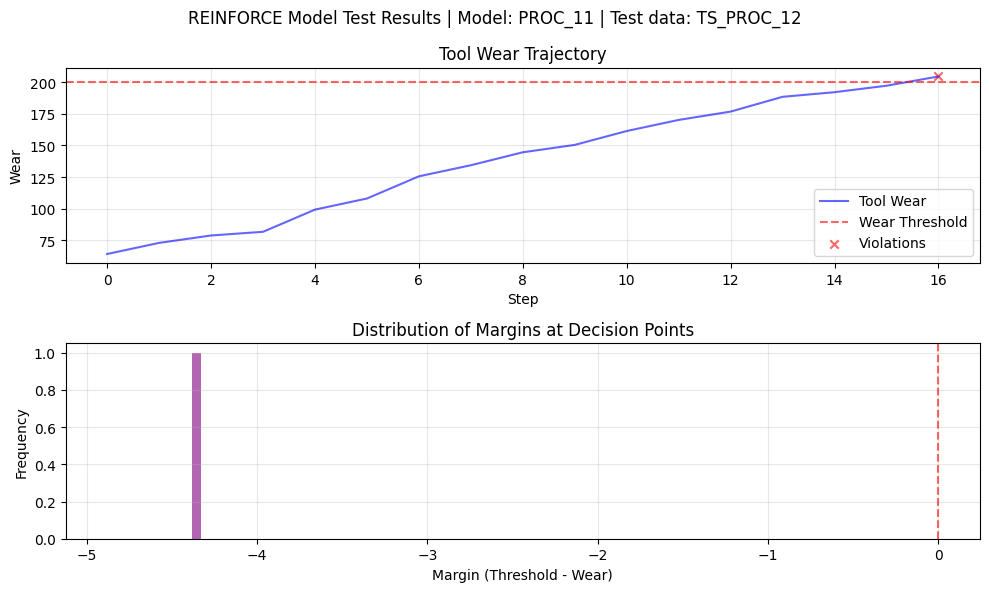


REINFORCE Test Results:
Total Steps: 17
Replacement Rate: 0.0000
Violation Rate: 0.0588
Average Margin: -4.38
Minimum Margin: -4.38


In [59]:
x = test_saved_model(
    model_file = REINFORCE_MODEL, 
    test_data_file = TEST_FILE, 
    wear_threshold = WEAR_THRESHOLD, 
    r1 = R1_CONTINUE, 
    r2 = R2_REPLACE, 
    r3 =  R3_VIOLATION,
    model_type = "REINFORCE"
)

#### Evaluating for correct action suggestion 

In [60]:
def evaluate_suggested_actions(model_file: str, test_data_file: str, wear_threshold: float, r1: float, r2: float, r3: float, model_type: str = "REINFORCE"):
    """
    Tests a saved model (REINFORCE or PPO) on new sensor data and visualizes the results.
    
    Args:
        model_file (str): Path to the saved model file
        test_data_file (str): Path to the new sensor data file
        wear_threshold (float): Threshold for tool wear
        r1, r2, r3 (float): Reward parameters for the environment
        model_type (str): Type of model to test ("REINFORCE" or "PPO")
    """
    
    import pandas as pd
    from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

    print(80*'-')
    print(f'MODEL: {MODEL_NAME}. Test data: {TEST_DATA}')
    print(80*'-')

    df = pd.read_csv(test_data_file)
    # load ground-truth action codes from CSV
    y_true_full = df['ACTION_CODE'].astype(int).to_numpy()
    n_test_records = len(y_true_full)-1
    print(f'Test file loaded: Records {len(y_true_full)}')

    # Create test environment
    test_env = MT_Env(data_file=test_data_file, wear_threshold=wear_threshold, r1=r1, r2=r2, r3=r3)
    
    # Load the appropriate model based on type
    if model_type.upper() == "REINFORCE":
        policy = PolicyNetwork(
            input_dim=test_env.observation_space.shape[0],
            output_dim=test_env.action_space.n
        )
        agent = REINFORCE(policy, test_env)
        try:
            checkpoint = torch.load(model_file)
            agent.policy.load_state_dict(checkpoint['policy_state_dict'])
            print(f"REINFORCE model loaded successfully from: {model_file}")
        except Exception as e:
            print(f"Error loading REINFORCE model: {str(e)}")
            return
        
    elif model_type.upper() == "REINFORCE_AM_MODEL":
        test_env = AM_Env(data_file=test_data_file, wear_threshold=wear_threshold, r1=r1, r2=r2, r3=r3)
        print('-- Using Attention-augmented Environment for testing.')
        policy = PolicyNetwork(
            input_dim=test_env.observation_space.shape[0],
            output_dim=test_env.action_space.n
        )
        agent = REINFORCE(policy, test_env)
        try:
            checkpoint = torch.load(model_file)
            agent.policy.load_state_dict(checkpoint['policy_state_dict'])
            print(f"REINFORCE model loaded successfully from: {model_file}")
        except Exception as e:
            print(f"Error loading REINFORCE model: {str(e)}")
            return

    elif model_type.upper() == "PPO":
        try:
            agent = PPO.load(model_file)
            print(f"PPO model loaded successfully from: {model_file}")
        except Exception as e:
            print(f"Error loading PPO model: {str(e)}")
            return
    else:
        raise ValueError("model_type must be either 'REINFORCE' or 'PPO'")
    
    # Test metrics
    total_steps = 0
    total_violations = 0
    total_replacements = 0
    predicted_actions = []
    
    # Run test episode
    obs, _ = test_env.reset()
    done = False
    step = 0

    for n in range(n_test_records):
        # Get action based on model type
        if model_type.upper() == "REINFORCE":
            action = agent.predict(obs)
            # print(f'-{n}:{action}-', end='')  
        else:  # PPO
            action, _states = agent.predict(obs)
            
        obs, reward, terminated, truncated, info = test_env.step(action)
        predicted_actions.append(action) 
        wear = obs[0]
        
        if info.get('replacement'):
            total_replacements += 1        
        if info.get('violation'):
            total_violations += 1
        
        step += 1
        done = terminated or truncated
    
    total_steps = step

    # align lengths
    n = len(predicted_actions)
    y_true = y_true_full[:n]
    print(f'\nPRED.[{n}]>> {predicted_actions}')
    print(f'ACTUAL[{len(y_true_full)}]>> {y_true_full}')

    # compute metrics (handle edge cases)
    precision = precision_score(y_true, predicted_actions, zero_division=0)
    recall = recall_score(y_true, predicted_actions, zero_division=0)
    f1 = f1_score(y_true, predicted_actions, zero_division=0)
    acc = accuracy_score(y_true, predicted_actions)

    metrics = {
        "precision": float(precision),
        "recall": float(recall),
        "f1": float(f1),
        "accuracy": float(acc),
        "predicted_actions": predicted_actions
    }

    print(f"\nREINFORCE test results — precision: {precision:.4f}, recall: {recall:.4f}, f1: {f1:.4f}, acc: {acc:.4f}\n\n")
    return metrics

In [66]:
from datetime import datetime
now = datetime.now()
formatted_datetime = now.strftime("%d-%b-%Y, %I:%M:%S %p")
print(formatted_datetime)

x = evaluate_suggested_actions(
    model_file = REINFORCE_MODEL, 
    test_data_file = TEST_FILE, 
    wear_threshold = WEAR_THRESHOLD, 
    r1 = R1_CONTINUE, 
    r2 = R2_REPLACE, 
    r3 = R3_VIOLATION,
    model_type = "REINFORCE"
)

26-Oct-2025, 08:15:19 PM
--------------------------------------------------------------------------------
MODEL: PROC_11. Test data: TS_PROC_12
--------------------------------------------------------------------------------
Test file loaded: Records 60
REINFORCE model loaded successfully from: models/PROC_11_REINFORCE_Model_10000.h5

PRED.[59]>> [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ACTUAL[60]>> [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

REINFORCE test results — precision: 0.0000, recall: 0.0000, f1: 0.0000, acc: 0.5085




C:\Users\Rajesh\AppData\Local\Temp\ipykernel_23064\1326816188.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_file)
